# Initial Testing Nixtla

## Import Required Library

In this code we will be working with Nixtla by instantiating the TimeGpt client. In order to demonstrate how the model works we will be using already cleaned electricity data that would range from the year 2018 to 2023 and then we will be using data from 2024 in order to test the model. 

In [204]:
from nixtla import NixtlaClient 
import os 
import dotenv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [12]:
# Let us get the api key from our .env file
dotenv.load_dotenv()
NIXTLA_API_KEY = os.getenv("NIXTLA_API_KEY")


# Then we will also set our working directory 
wd = os.getcwd()

In [ ]:
# Instantiate Nixlat Client 
nixtla_client = NixtlaClient( 

    api_key=NIXTLA_API_KEY
)

In [ ]:
# Validating API Key 
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

Now that we have received the confirmation from Nixtla we can proceed with our forecasting of electricity demand and price. Let us load our data, now the data we are using has already been processed and we have checked for any duplicates or any missing values.

In [ ]:
# Let us load our data
italy_train = pd.read_csv('data/italy_train.csv')
italy_test = pd.read_csv('data/italy_test.csv')

In [ ]:
# Sanity check to see if the data type is actually checking out or not 
italy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    52608 non-null  datetime64[ns]
 1   Load    52608 non-null  float64       
 2   Price   52608 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [ ]:
# Inspect the first five values of our dataset 
italy_train.head()

,Time,Load,Price
0,2017-12-31 00:00:00,20508.0,43.5
1,2017-12-31 01:00:00,19399.0,40.1
2,2017-12-31 02:00:00,19041.0,36.5
3,2017-12-31 03:00:00,19117.0,36.5
4,2017-12-31 04:00:00,19623.0,38.0


Now we can see that our data actually starts from the last day of the year 2017, so we will be dropping the last day. 

In [ ]:
# Let us rename the "Unnamed:0" column to Time
italy_train = italy_train.rename(columns={"Unnamed: 0": "Time"})
italy_test = italy_test.rename(columns={"Unnamed: 0": "Time"})

# Then let us make the correct conversion of the data type for the italy_train and italy_test 
italy_train['Time'] = pd.to_datetime(italy_train['Time'])
italy_test['Time'] = pd.to_datetime(italy_test['Time'])

In [94]:
italy_train = italy_train[italy_train['Time'] >= '2018-01-01']

In [95]:
italy_train.head()

,Time,Load,Price
24,2018-01-01 00:00:00,22305.0,44.16
25,2018-01-01 01:00:00,20971.0,42.24
26,2018-01-01 02:00:00,19875.0,39.29
27,2018-01-01 03:00:00,19074.0,36.00
28,2018-01-01 04:00:00,19346.0,41.99


Great now that we have ensured that the data is actually in line. Now let us visually inspect what our data for price looks like. 

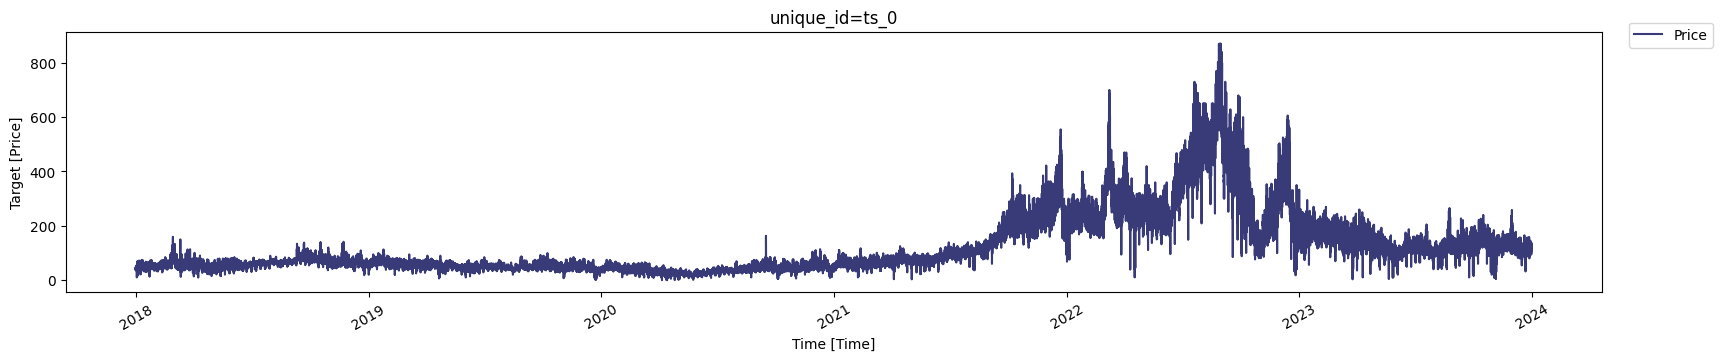

In [89]:
# Let us gain an understaning of how price moved over time from 2018 up until 2024
nixtla_client.plot(italy_train,  target_col='Price', time_col='Time')

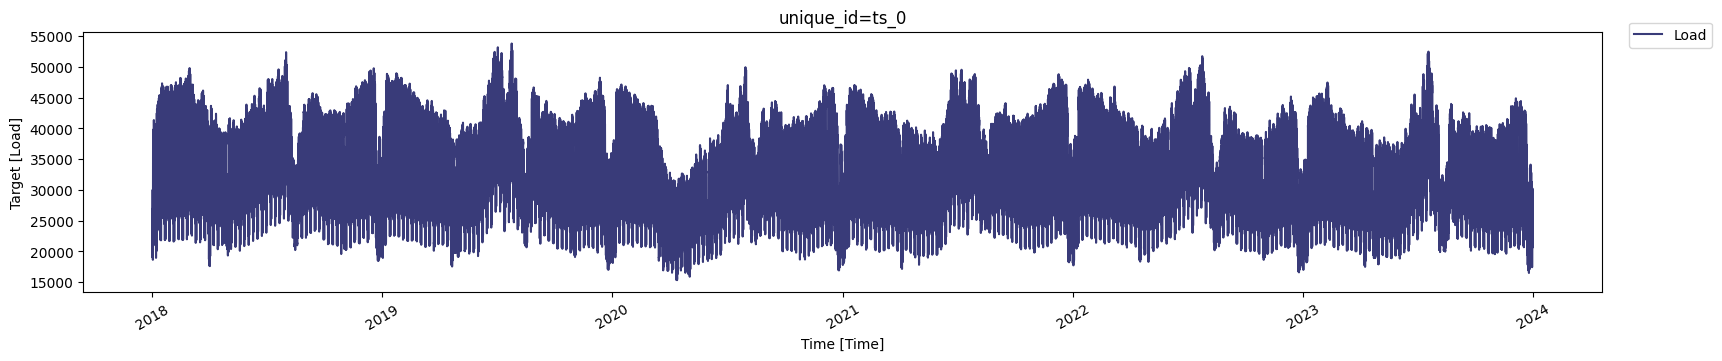

In [105]:
nixtla_client.plot(italy_train,  target_col = 'Load', time_col = 'Time')

In [ ]:
forecasting_time_30d = nixtla_client.forecast(df= italy_train, h = 30, freq = "h", 
                                            target_col = 'Price',
                                            time_col = 'Time')

INFO:nixtla.nixtla_client:Validating inputs...
/Users/hn/Documents/Portfolio/TimeGpt/.time_gpt/lib/python3.12/site-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['Load'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [85]:
forecasting_time_30d['Time'] = pd.to_datetime(forecasting_time_30d['Time'])
italy_test['Time'] = pd.to_datetime(italy_test['Time'])


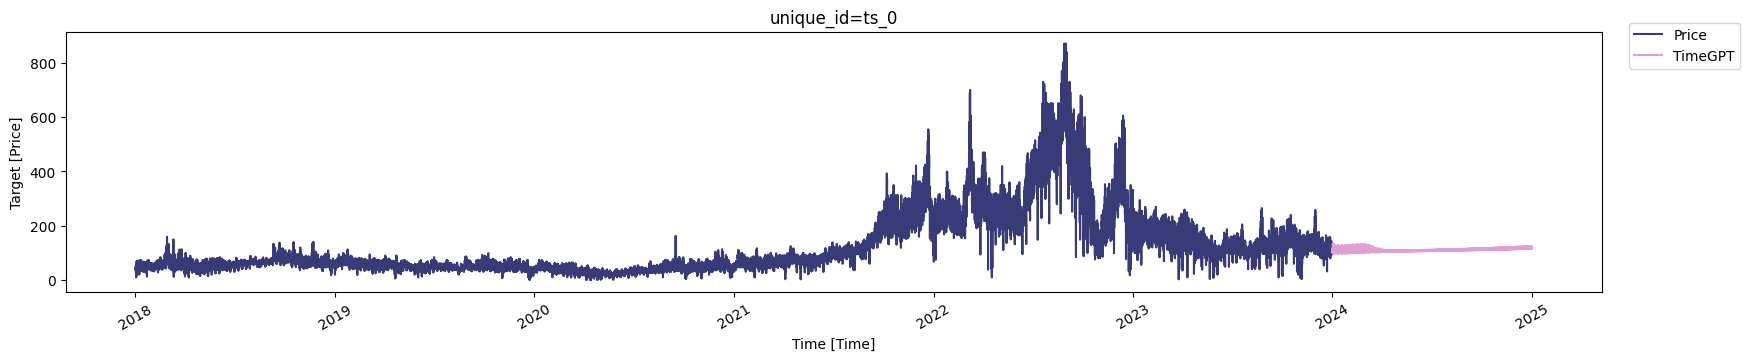

In [103]:
nixtla_client.plot(italy_train, forecasting_time_30d, target_col = 'Price', time_col = 'Time')

In [159]:
# Defining the forecasting 
forecast_start = italy_train['Time'].max() + pd.Timedelta(hours=1)
forecast_end = italy_test['Time'].max()
forecast_horizon = pd.Timedelta(days = 30)
window_size = timedelta(days=30)
step_size = pd.Timedelta(days = 30)

# We will create a container for all of the forecasts 
all_forecast = []

In [160]:
current_train_start = italy_train['Time'].min()
current_train_end = forecast_start
current_forecast_start = forecast_start

In [124]:
current_train_start

Timestamp('2018-12-27 00:00:00')

In [145]:
while current_forecast_start + forecast_horizon <= forecast_end: 


    train_data = italy_train[(italy_train['Time'] >= current_train_start) &
                            ( italy_train['Time'] < current_train_end)]
    
    # Sanity check
    if train_data.empty:
        print(f"No data found between {current_train_start} and {current_train_end}")
        break
    

    forecast = nixtla_client.forecast(df = train_data, h = 720, 
                                      freq = 'h', 
                                      target_col = 'Price',
                                      time_col = 'Time')
    



    

    all_forecast.append(forecast)


    # Advance window
    current_train_start += window_size
    current_train_end += window_size
    current_forecast_start += step_size




INFO:nixtla.nixtla_client:Validating inputs...
/Users/hn/Documents/Portfolio/TimeGpt/.time_gpt/lib/python3.12/site-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['Load'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
/Users/hn/Documents/Portfolio/TimeGpt/.time_gpt/lib/python3.12/site-packages/nixtla/nixtla_client.py:383: UserWarning: `df` contains the following exogenous features: ['Load'], but `X_df` was not provided and they were not declared in `hist_exog_list`. They will be ignored.
  warnings.warn(
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtl

In [138]:
# Combine all forecasts into one DataFrame
forecast_df = pd.concat(all_forecast, ignore_index=True)

In [147]:
all_forecast

[                   Time     TimeGPT
 0   2024-01-01 00:00:00  105.151146
 1   2024-01-01 01:00:00  102.092780
 2   2024-01-01 02:00:00  100.211350
 3   2024-01-01 03:00:00   99.402695
 4   2024-01-01 04:00:00  105.387540
 ..                  ...         ...
 715 2024-01-30 19:00:00  121.568910
 716 2024-01-30 20:00:00  114.310400
 717 2024-01-30 21:00:00  109.864050
 718 2024-01-30 22:00:00  106.940765
 719 2024-01-30 23:00:00  103.394550
 
 [720 rows x 2 columns],
                    Time     TimeGPT
 0   2024-01-01 00:00:00  105.151146
 1   2024-01-01 01:00:00  102.092780
 2   2024-01-01 02:00:00  100.211350
 3   2024-01-01 03:00:00   99.402695
 4   2024-01-01 04:00:00  105.387540
 ..                  ...         ...
 715 2024-01-30 19:00:00  121.568910
 716 2024-01-30 20:00:00  114.310400
 717 2024-01-30 21:00:00  109.864050
 718 2024-01-30 22:00:00  106.940765
 719 2024-01-30 23:00:00  103.394550
 
 [720 rows x 2 columns],
                    Time     TimeGPT
 0   2024-01-01 00:00

@

In [154]:
new_forecast = []

# Electricity Italian Price 

In [196]:
# 1) Copy your static training set
history = italy_train.copy()

forecast_horizon = timedelta(hours=720)    # 30 days
step_size       = timedelta(days=30)

# 2) Define the first and last forecast starts from your test set
forecast_start = italy_test['Time'].min().floor('D')       # e.g. 2024-01-01
forecast_stop  = italy_test['Time'].max().floor('D')       # e.g. 2024-12-01

all_forecasts = []

while forecast_start <= forecast_stop:
    # a) Forecast 30 days ahead from current history
    fc = nixtla_client.forecast(
        df=history[['Time','Price']],
        h=720,
        freq='h',
        time_col='Time',
        target_col='Price'
    )
    fc['forecast_start'] = forecast_start
    all_forecasts.append(fc)
    print(f"✅ Forecasted {forecast_start.date()} → {(forecast_start+forecast_horizon).date()}")

    # b) Now pull the *actual* observed block from italy_test
    obs_start = forecast_start
    obs_end   = forecast_start + forecast_horizon
    observed  = italy_test[
        (italy_test['Time'] >= obs_start) &
        (italy_test['Time'] <  obs_end)
    ]

    # c) Append the observed block to your history
    history = pd.concat([history, observed], ignore_index=True).sort_values('Time')

    # d) Step forward
    forecast_start += step_size


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-01-01 → 2024-01-31


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-01-31 → 2024-03-01


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-03-01 → 2024-03-31


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-03-31 → 2024-04-30


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-04-30 → 2024-05-30


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-05-30 → 2024-06-29


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-06-29 → 2024-07-29


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-07-29 → 2024-08-28


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-08-28 → 2024-09-27


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-09-27 → 2024-10-27


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-10-27 → 2024-11-26


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Forecasted 2024-11-26 → 2024-12-26
✅ Forecasted 2024-12-26 → 2025-01-25


In [200]:
all_forecasts

[                   Time     TimeGPT forecast_start
 0   2024-01-01 00:00:00  105.151140     2024-01-01
 1   2024-01-01 01:00:00  102.092780     2024-01-01
 2   2024-01-01 02:00:00  100.211340     2024-01-01
 3   2024-01-01 03:00:00   99.402695     2024-01-01
 4   2024-01-01 04:00:00  105.387540     2024-01-01
 ..                  ...         ...            ...
 715 2024-01-30 19:00:00  121.568920     2024-01-01
 716 2024-01-30 20:00:00  114.310394     2024-01-01
 717 2024-01-30 21:00:00  109.864044     2024-01-01
 718 2024-01-30 22:00:00  106.940760     2024-01-01
 719 2024-01-30 23:00:00  103.394554     2024-01-01
 
 [720 rows x 3 columns],
                    Time     TimeGPT forecast_start
 0   2024-01-31 00:00:00   91.428734     2024-01-31
 1   2024-01-31 01:00:00   87.711000     2024-01-31
 2   2024-01-31 02:00:00   86.426010     2024-01-31
 3   2024-01-31 03:00:00   87.033356     2024-01-31
 4   2024-01-31 04:00:00   90.868090     2024-01-31
 ..                  ...         ... 

In [209]:
forecast_df = pd.concat(all_forecasts, ignore_index=True)


In [210]:
# A helper for MAPE
def mape(actual, pred):
    return (abs((actual - pred) / actual) * 100).mean()

# 1) Merge forecasts with actuals
merged = forecast_df.merge(
    italy_test[['Time', 'Price']].rename(columns={'Price': 'Actual'}),
    on='Time',
    how='inner'  # only times we have both
)


In [214]:
# 2) Compute error metrics per forecast window
rows = []
for start, grp in merged.groupby('forecast_start'):
    y_true = grp['Actual']
    y_pred = grp['TimeGPT']
    rows.append({
        'forecast_start': pd.to_datetime(start).date(),
        'MSE':  mean_squared_error(y_true, y_pred),
        'MAE':  mean_absolute_error(y_true, y_pred),
        'MAPE': mape(y_true, y_pred)
    })

# 3) Compute overall metrics across all windows
overall = {
    'forecast_start': 'Overall',
    'MSE':  mean_squared_error(merged['Actual'], merged['TimeGPT']),
    'MAE':  mean_absolute_error(merged['Actual'], merged['TimeGPT']),
    'MAPE': mape(merged['Actual'], merged['TimeGPT'])
}
rows.append(overall)



In [216]:
metrics_df = pd.DataFrame(rows)

# Split “Overall” out
per_window = metrics_df[metrics_df['forecast_start'] != 'Overall'].copy()
overall    = metrics_df[metrics_df['forecast_start'] == 'Overall'].copy()

# Ensure per_window.forecast_start is datetime, then sort
per_window['forecast_start'] = pd.to_datetime(per_window['forecast_start'])
per_window = per_window.sort_values('forecast_start')

# (Optionally, format that column back to date-only strings)
per_window['forecast_start'] = per_window['forecast_start'].dt.date.astype(str)

# Recombine with the Overall row at the bottom
metrics_df = pd.concat([per_window, overall], ignore_index=True)

print(metrics_df)

   forecast_start          MSE        MAE        MAPE
0      2024-01-01   310.096886  14.048787   16.538476
1      2024-01-31   181.363195  10.254035   12.889049
2      2024-03-01   575.447735  20.230028   41.046567
3      2024-03-31   668.557875  19.104548  176.453737
4      2024-04-30   644.079051  20.607062   39.186554
5      2024-05-30   444.034177  16.612173   21.861715
6      2024-06-29   282.925910  11.465255   16.924935
7      2024-07-29   436.725200  15.050694   11.263976
8      2024-08-28   662.444356  20.215011   18.372411
9      2024-09-27   481.864545  14.750661   35.669452
10     2024-10-27   586.981000  18.905626   13.731626
11     2024-11-26   885.276919  21.111267   22.931810
12     2024-12-26  1173.198327  28.551962   20.480418
13        Overall   524.134141  17.054552   35.325114


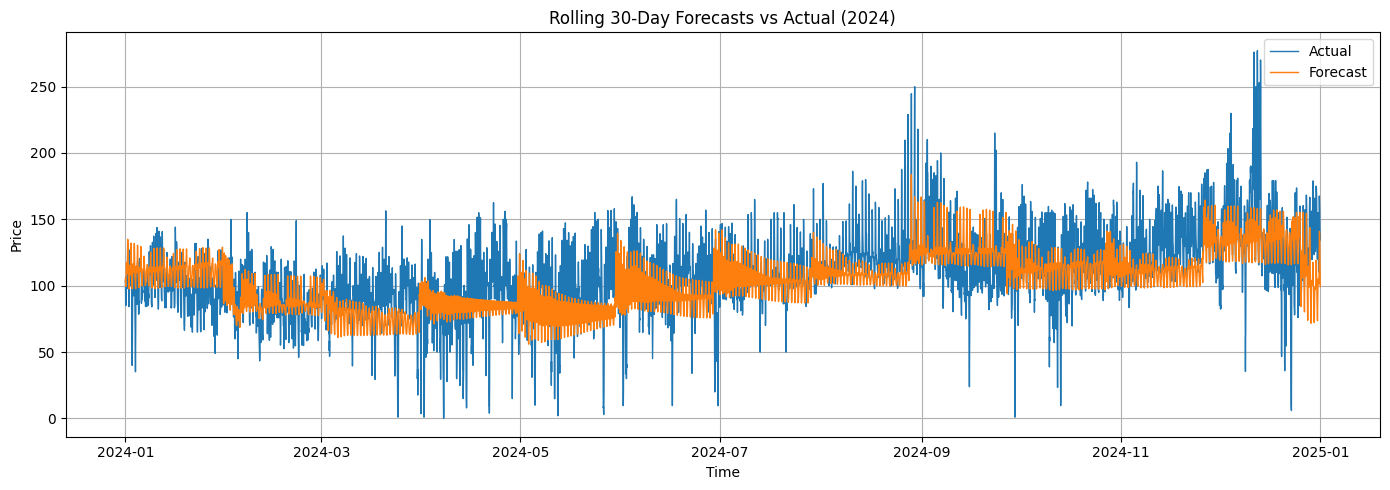

In [212]:
# 3) Plot the rolling forecasts against actuals
plt.figure(figsize=(14, 5))
plt.plot(merged['Time'], merged['Actual'], label='Actual',   linewidth=1)
plt.plot(merged['Time'], merged['TimeGPT'],  label='Forecast', linewidth=1)
plt.title('Rolling 30-Day Forecasts vs Actual (2024)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Eelectricity Italian Load 

In [217]:
history = italy_train.copy()
forecast_horizon = timedelta(hours=720)
step_size       = timedelta(days=30)

forecast_start = italy_test['Time'].min().floor('D')
forecast_stop  = italy_test['Time'].max().floor('D')

all_load_forecasts = []

while forecast_start <= forecast_stop:
    # forecast next 30 days of Load
    fc = nixtla_client.forecast(
        df=history[['Time','Load']],
        h=720,
        freq='h',
        time_col='Time',
        target_col='Load'
    )
    fc['forecast_start'] = forecast_start
    all_load_forecasts.append(fc)

    # append the actual 30-day Load block to history
    obs = italy_test[
        (italy_test['Time'] >= forecast_start) &
        (italy_test['Time'] <  forecast_start + forecast_horizon)
    ][['Time','Load']]
    history = pd.concat([history, obs], ignore_index=True).sort_values('Time')

    forecast_start += step_size

forecast_load_df = pd.concat(all_load_forecasts, ignore_index=True)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Foreca

In [221]:
# Merge predicted Load with actual
merged_load = (
    forecast_load_df
    .merge(
      italy_test[['Time','Load']].rename(columns={'Load':'ActualLoad'}),
      on='Time', how='inner'
    )
)

# helper
def mape(a, p): 
    return (abs((a-p)/a)*100).mean()

# per-window metrics
rows = []
for start, grp in merged_load.groupby('forecast_start'):
    y_true = grp['ActualLoad']
    y_pred = grp['TimeGPT']
    rows.append({
      'forecast_start': start.date(),
      'MSE':  mean_squared_error(y_true, y_pred),
      'MAE':  mean_absolute_error(y_true, y_pred),
      'MAPE': mape(y_true, y_pred)
    })

# overall
rows.append({
  'forecast_start':'Overall',
  'MSE':  mean_squared_error(merged_load['ActualLoad'], merged_load['TimeGPT']),
  'MAE':  mean_absolute_error(merged_load['ActualLoad'], merged_load['TimeGPT']),
  'MAPE': mape(merged_load['ActualLoad'], merged_load['TimeGPT'])
})

metrics_load_df = pd.DataFrame(rows)

# sort per‐window then append overall
perw = metrics_load_df[metrics_load_df.forecast_start!='Overall'].copy()
perw['forecast_start']=pd.to_datetime(perw['forecast_start'])
perw=perw.sort_values('forecast_start')
perw['forecast_start']=perw['forecast_start'].dt.date.astype(str)
metrics_load_df = pd.concat([perw, metrics_load_df[metrics_load_df.forecast_start=='Overall']], ignore_index=True)

print(metrics_load_df)


   forecast_start           MSE          MAE       MAPE
0      2024-01-01  1.208138e+08  9094.878374  25.689691
1      2024-01-31  2.294187e+07  3454.453482  11.334404
2      2024-03-01  2.370098e+07  3561.181458  12.273425
3      2024-03-31  1.922221e+07  3548.562774  12.867939
4      2024-04-30  2.039880e+07  3968.115056  13.653112
5      2024-05-30  2.059407e+07  3683.218801  11.799122
6      2024-06-29  5.327627e+07  5777.729631  14.818343
7      2024-07-29  1.995129e+07  3602.168411  11.553487
8      2024-08-28  2.075440e+07  3854.174321  12.220882
9      2024-09-27  1.776829e+07  3170.615207  11.097456
10     2024-10-27  4.581941e+07  5283.464583  16.327445
11     2024-11-26  2.344955e+07  3773.320504  11.232689
12     2024-12-26  3.299042e+06  1390.806514   5.241061
13        Overall  3.355334e+07  4348.364254  13.599689


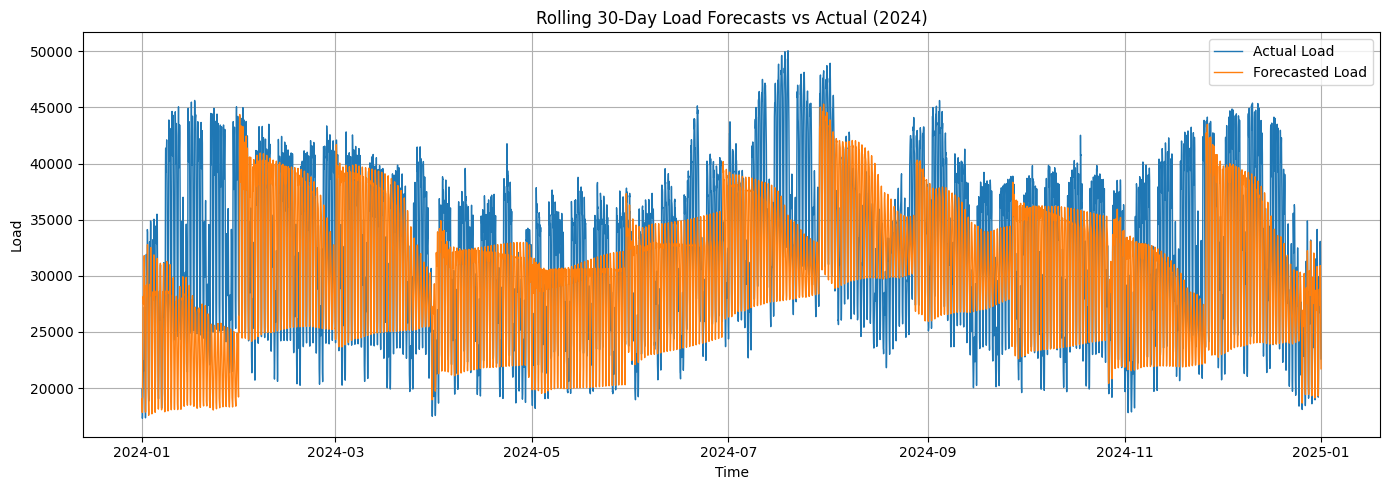

In [223]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(merged_load['Time'], merged_load['ActualLoad'], label='Actual Load', linewidth=1)
plt.plot(merged_load['Time'], merged_load['TimeGPT'], label='Forecasted Load', linewidth=1)
plt.title('Rolling 30-Day Load Forecasts vs Actual (2024)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
